# Imports

In [10]:
import pandas as pd
import seaborn as sb
import matplotlib
from matplotlib import cm
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

matplotlib.style.use('ggplot')
%matplotlib notebook
import mpld3
mpld3.enable_notebook()

## Retrieve Data

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

/Users/Jojo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Exploration

In [3]:
train_data.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [4]:
train_data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


# Baseline model

In [5]:
# feature: words per question

def count_words(question):
    question = str(question)
    words = question.split()
    return len(words)

train_data["q1l"] = train_data["question1"].apply(count_words)
train_data["q2l"] = train_data["question2"].apply(count_words)
test_data["q1l"] = test_data["question1"].apply(count_words)
test_data["q2l"] = test_data["question2"].apply(count_words)

In [6]:
# feature: repeated words per question

def count_repeats(row):
    q1 = str(row['question1']).lower()
    q2 = str(row['question2']).lower()
    
    w1 = q1.split()
    w2 = q2.split()
    
    count = 0
    
    if len(w1) > len(w2):
        for word in w1:
            if word in w2:
                count = count + 1
    else:
        for word in w2:
            if word in w1:
                count = count + 1
    
    return count

train_data["repeats"] = train_data.apply(count_repeats, axis=1)
test_data["repeats"] = test_data.apply(count_repeats, axis=1)

##### Initial Test

In [41]:
tp = 0
tn = 0
fp = 0
fn = 0

for index, row in train_data.iterrows():
    if (row['repeats']/row['q1l'] + row['repeats']/row['q2l'])/2 >= 0.5:
        if row['is_duplicate'] == 1:
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if row['is_duplicate'] == 1:
            fn = fn + 1
        else:
            tn = tn + 1

Accuracy:  0.6695490860520913


In [42]:
print("Accuracy: ", (tp+tn)/(tp+tn+fp+fn))
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives: ", tp)
print("True negatives: ", tn)

Accuracy:  0.6695490860520913
False positives:  87292
False negatives:  46306
True positives:  102957
True negatives:  167735


#### Results Visualization

### Ready train/validation

In [8]:
features = ["repeats", "q1l", "q2l"]

X = train_data[features]
y = train_data["is_duplicate"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33)

### Random Forest Classifier

0.6992639563470648


<IPython.core.display.Javascript object>


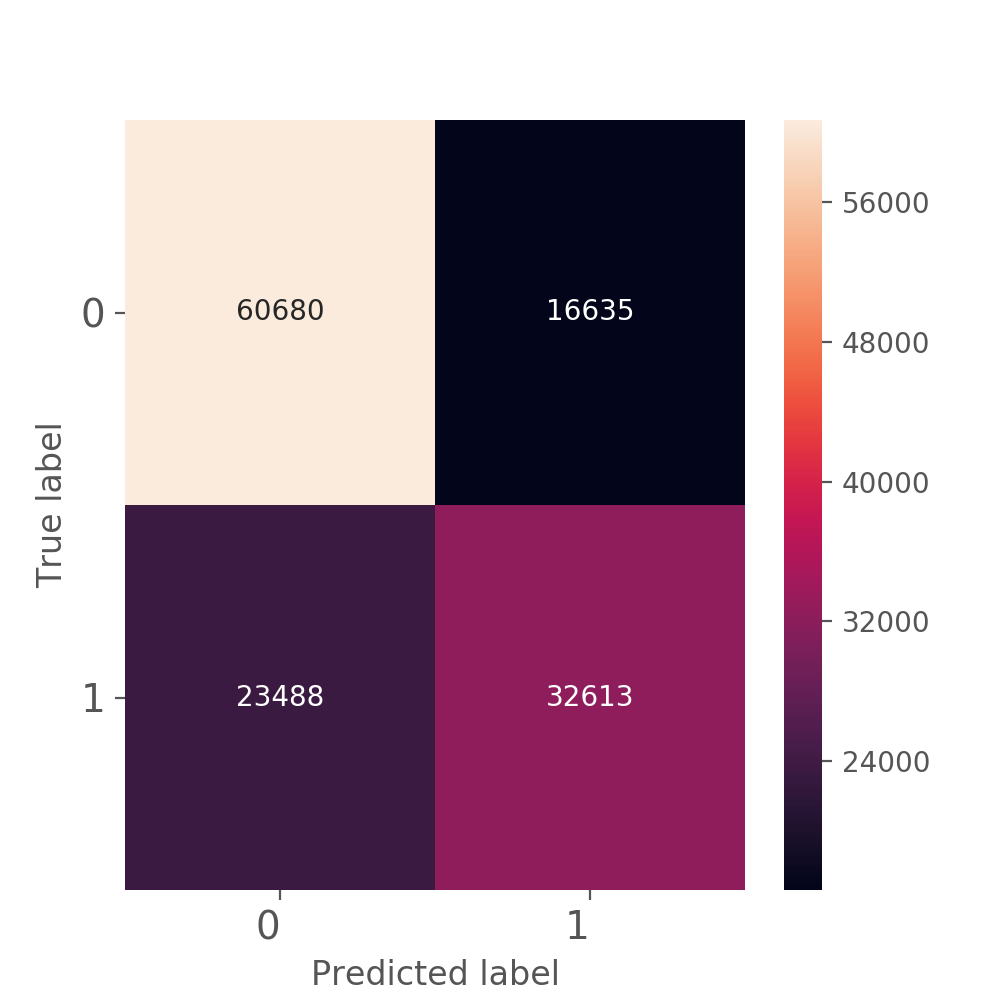

In [18]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predict = rfc.predict(X_val)
rfc_cm = confusion_matrix(rfc_predict, y_val)
print(accuracy_score(rfc_predict, y_val))

plt.figure(figsize=[5,5])
heatmap = sb.heatmap(rfc_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()